<a href="https://colab.research.google.com/github/delte1821/ML-SERS/blob/master/ML_SERS_v1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def initialize_paths(file_path):
    figure_path = os.path.join(file_path, "Figures")
    return figure_path

In [8]:
def load_data(file_path):
    df = pd.read_excel(file_path, header=None)
    materials = df.iloc[0, :].astype(int)  # Ensure materials are integers
    concentrations = df.iloc[1, :].astype(float)
    data = df.iloc[2:, :].values
    return data, materials, concentrations

In [9]:
def filter_by_material(data, materials, concentrations, material_type):
    indices = materials == material_type
    filtered_data = data[:, indices]
    filtered_concentrations = concentrations[indices]
    return filtered_data, filtered_concentrations

In [10]:
def preprocess_data(data, degree=2):
    nsamples, nx, ny = data.shape
    data_2d = data.reshape((nsamples, nx * ny))
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_2d)
    poly = PolynomialFeatures(degree=degree)
    data_poly = poly.fit_transform(data_scaled)
    data_reshaped = data_poly.reshape(nsamples, -1)
    return data_reshaped

In [11]:
def augment_data(data, labels, num_augmented_samples=10):
    augmented_data = []
    augmented_labels = []
    for sample, label in zip(data, labels):
        for _ in range(num_augmented_samples):
            noise = np.random.normal(0, 0.1, sample.shape)
            augmented_sample = sample + noise
            augmented_data.append(augmented_sample)
            augmented_labels.append(label)
    return np.array(augmented_data), np.array(augmented_labels)

In [12]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(100, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, kernel_regularizer=l2(0.01))  # Output layer for concentration prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [13]:
def remove_outliers(X, y):
    z_scores_X = (X - np.mean(X)) / np.std(X)
    z_scores_y = (y - np.mean(y)) / np.std(y)
    threshold = 3
    non_outliers_X = X[abs(z_scores_X) <= threshold]
    non_outliers_y = y[abs(z_scores_y) <= threshold]
    # Ensure both X and y have the same number of samples
    min_samples = min(len(non_outliers_X), len(non_outliers_y))

    non_outliers_X = non_outliers_X[:min_samples]
    non_outliers_y = non_outliers_y[:min_samples]

    # Replace the original data with the non-outliers
    X = non_outliers_X
    y = non_outliers_y
    return X, y

In [14]:
def train_and_validate(data, materials, concentrations, material_types, degree=2, display=True, figure_path=None):
    results = {}
    fig_counter = 1
    for mat_type in material_types:
        X, y = filter_by_material(data, materials, concentrations, mat_type)
        X_train, X_val, y_train, y_val = train_test_split(X.T, y, test_size=0.2, random_state=42)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

        # Data augmentation
        X_train, y_train = augment_data(X_train, y_train)

        X_train = preprocess_data(X_train, degree=degree)
        X_val = preprocess_data(X_val, degree=degree)

        # Reshape back to 3D for CNN input
        X_train = X_train.reshape(X_train.shape[0], -1, 1)
        X_val = X_val.reshape(X_val.shape[0], -1, 1)

        model = build_cnn_model((X_train.shape[1], 1))
        print(f"Training model for material type: {mat_type}")
        history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        results[mat_type] = (mse, r2, model)

        if display:
            plot_predictions(y_val, y_pred, mat_type, fig_counter, figure_path)
            plot_training_history(history, mat_type, fig_counter, figure_path)

        fig_counter += 1
    return results

In [15]:
def plot_predictions(y_true, y_pred, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Concentrations')
    plt.ylabel('Predicted Concentrations')
    plt.title(f'Actual vs Predicted Concentrations for {material_name}')
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png'))
    plt.show()

In [16]:
def plot_training_history(history, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Epoch vs Loss for {material_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png'))
    plt.show()

In [17]:
def classify_materials(data, materials, display=True, figure_path=None):
    data = data.T

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)

    assert data_pca.shape[0] == len(materials), "Inconsistent number of samples between data and materials"

    X_train, X_val, y_train, y_val = train_test_split(data_pca, materials, test_size=0.2, random_state=42)

    X_train, y_train = augment_data(X_train, y_train)

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train_encoded)
    y_pred = clf.predict(X_val)

    y_pred_decoded = le.inverse_transform(y_pred)

    target_names = [str(label) for label in le.classes_]

    print("Material Classification Report (Validation):")
    print(classification_report(y_val_encoded, y_pred, target_names=target_names))

    if display:
        plot_confusion_matrix(y_val_encoded, y_pred, target_names, figure_path)

In [18]:
def plot_confusion_matrix(y_true, y_pred, labels, figure_path, fig_counter=1):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.figure(figsize=(8, 6))
    plt.tight_layout()
    plt.savefig(os.path.join(figure_path, f'CM_{fig_counter}.png'))
    plt.show()

In [19]:
# Paths and instantiation
file_path = "/content/drive/My Drive/Colab Notebooks/Spectra/Low"
figure_path = initialize_paths(file_path)
original_file_path = os.path.join(file_path, "Combine.xlsx")
display = True

In [20]:
# Instantiate and use the model
data, materials, concentrations = load_data(original_file_path)
material_types = [1, 2]  # Focusing on IL6 and TNF for example
degree = 2

In [ ]:
# Regression
results_regression = train_and_validate(data, materials, concentrations, material_types, degree=degree, display=display, figure_path=figure_path)

Training model for material type: 1


Data shape after transpose: (232, 1024)
Materials length: 232
Material Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.91      0.95      0.93        22
           2       0.86      1.00      0.92        18

    accuracy                           0.87        47
   macro avg       0.81      0.75      0.75        47
weighted avg       0.85      0.87      0.85        47



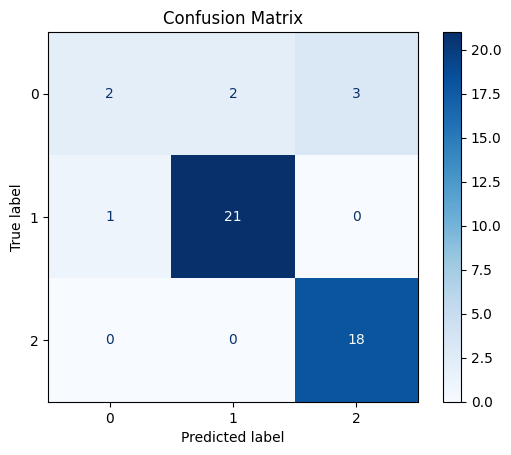

<Figure size 800x600 with 0 Axes>

In [47]:
# Classification
sers_model.classify_materials(data, materials)